# Decision Tree: Income Prediction

In this lab, we will build a decision tree to predict the income of a given population, which is labelled as <=$50K and >$50K. The attributes (predictors) are age, working class type, marital status, gender, race etc.


In the following sections, we'll:
- clean and prepare the data, 
- build a decision tree with default hyperparameters, 
- understand all the hyperparameters that we can tune, and finally
- choose the optimal hyperparameters using grid search cross-validation.


<hr>

### Understanding and Cleaning the Data

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from os import system
%matplotlib inline

In [2]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [37]:
# Reading the csv file and putting it into 'df' object.
df = pd.read_csv('adult_dataset.csv')

In [ ]:
# Let's understand the type of values in each column of our dataframe 'df'.
df.info()

In [ ]:
# Let's understand the data, how it look like.
df.head()

You can observe that the columns workclass and occupation consist of missing values which are represented as '?' in the  dataframe.

On looking a bit more closely, you will also find that whenever workclass is having a missing value, occupation is also missing in that row. Let's check how may rows are missing.

In [ ]:
# rows with missing values represented as'?'.
df_1 = df[df.workclass == '?']
df_1

Now we can check the number of rows in df_1.

In [ ]:
df_1.info()

There are 1836 rows with missing values, which is about 5% of the total data. We choose to simply drop these rows.

In [16]:
# dropping the rows having missing values in workclass
df = df[df['workclass'] != '?']
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K


Let's see whether any other columns contain a "?". Since "?" is a string, we can apply this check only on the categorical columns.

In [17]:
# select all categorical variables
df_categorical = df.select_dtypes(include=['object'])

# checking whether any other columns contain a "?"
df_categorical.apply(lambda x: x=="?", axis=0).sum()

workclass           0
education           0
marital.status      0
occupation          7
relationship        0
race                0
sex                 0
native.country    556
income              0
dtype: int64

Thus, the columns occupation and native.country contain some "?"s. Let's get rid of them.

In [18]:
# dropping the "?"s
df = df[df['occupation'] != '?']
df = df[df['native.country'] != '?']

Now we have a clean dataframe which is ready for model building.<br>

In [ ]:
# clean dataframe
df.info()

## Data Preparation

There are a number of preprocessing steps we need to do before building the model. 

Firstly, note that we have both categorical and numeric features as predictors. In previous models such as linear and logistic regression, we had created **dummy variables** for categorical variables, since those models (being mathematical equations) can  process only numeric variables.

All that is not required in decision trees, since they can process categorical variables easily. However, we still need to **encode the categorical variables** into a standard format so that sklearn can understand them and build the tree. We'll do that using the ```LabelEncoder()``` class, which comes with ```sklearn.preprocessing```. 

You can read the documentation of ```LabelEncoder``` <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html">here</a>.





In [19]:
from sklearn import preprocessing


# encode categorical variables using Label Encoder

# select all categorical variables
df_categorical = df.select_dtypes(include=['object'])
df_categorical.head()

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
1,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,United-States,<=50K
3,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,United-States,<=50K
4,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female,United-States,<=50K
5,Private,HS-grad,Divorced,Other-service,Unmarried,White,Female,United-States,<=50K
6,Private,10th,Separated,Adm-clerical,Unmarried,White,Male,United-States,<=50K


In [ ]:
# apply Label encoder to df_categorical

le = preprocessing.LabelEncoder()
df_categorical = df_categorical.apply(le.fit_transform)
df_categorical.head()
df_categorical.dtypes

In [ ]:
# concat df_categorical with original df
df = df.drop(df_categorical.columns, axis=1)
df = pd.concat([df, df_categorical], axis=1)
df.head()

In [1]:
## One hot encoding also can be used for converting categorical data to numerical data ##
#onehotencod = pd.get_dummies(df[['workclass','education','marital.status','occupation','relationship','race','sex','native.country']])
#onehotencod.head()
#df.drop(['workclass','education','marital.status','occupation','relationship','race','sex','native.country'], axis=1, inplace=True)
#df = pd.concat([df, onehotencod], axis=1)
#df.head()
#df = pd.concat([df,onehotencod],axis=1)

In [22]:
# look at column types
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 1 to 32560
Columns: 203 entries, age to native.country_Yugoslavia
dtypes: int64(6), object(1), uint8(196)
memory usage: 7.5+ MB


,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
1,82,132870,9,0,4356,18,<=50K,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,54,140359,4,0,3900,40,<=50K,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,41,264663,10,0,3900,40,<=50K,0,0,1,...,0,0,0,0,0,0,0,1,0,0
5,34,216864,9,0,3770,45,<=50K,0,0,1,...,0,0,0,0,0,0,0,1,0,0
6,38,150601,6,0,3770,40,<=50K,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [23]:
# convert target variable income to categorical
df['income'] = df['income'].astype('category')

Now all the categorical variables are suitably encoded. Let's build the model.

<hr>

### Model Building and Evaluation

Let's first build a decision tree with default hyperparameters. Then we'll use cross-validation to tune them.

In [24]:
# Importing train-test-split 
from sklearn.model_selection import train_test_split

In [25]:
# Putting feature variable to X
X = df.drop('income',axis=1)

# Putting response variable to y
y = df['income']

In [26]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state = 99)
X_train.head()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
24351,42,289636,9,0,0,46,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
15626,37,52465,9,0,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4347,38,125933,14,0,0,40,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23972,44,183829,13,0,0,38,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
26843,35,198841,11,0,0,35,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [27]:
y_train=pd.DataFrame(y_train)
y_test=pd.DataFrame(y_test)
#X_train.to_csv('X_train.csv') 
#X_test.to_csv('X_test.csv')
#y_train.to_csv('y_train.csv')
#y_test.to_csv('y_test.csv')

In [28]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(max_depth=5)
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [29]:
# Let's check the evaluation metrics of our default model

# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
y_pred_default = dt_default.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred_default))

              precision    recall  f1-score   support

       <=50K       0.86      0.96      0.90      6867
        >50K       0.78      0.50      0.61      2182

   micro avg       0.84      0.84      0.84      9049
   macro avg       0.82      0.73      0.76      9049
weighted avg       0.84      0.84      0.83      9049



In [30]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_test,y_pred_default))
print(accuracy_score(y_test,y_pred_default))

[[6559  308]
 [1095 1087]]
0.8449552436733341


<hr>

### Plotting the Decision Tree

To visualise decision trees in python, you need to install certain external libraries. You can read about the process in detail here: http://scikit-learn.org/stable/modules/tree.html

We need the ```graphviz``` library to plot a tree.

In [31]:
# Importing required packages for visualization
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
#import pydot, graphviz
#!pip install pydotplus
import pydotplus

# Putting features
features = list(df.columns[1:])
features

['fnlwgt',
 'education.num',
 'capital.gain',
 'capital.loss',
 'hours.per.week',
 'income',
 'workclass_Federal-gov',
 'workclass_Local-gov',
 'workclass_Private',
 'workclass_Self-emp-inc',
 'workclass_Self-emp-not-inc',
 'workclass_State-gov',
 'workclass_Without-pay',
 'education_10th',
 'education_11th',
 'education_12th',
 'education_1st-4th',
 'education_5th-6th',
 'education_7th-8th',
 'education_9th',
 'education_Assoc-acdm',
 'education_Assoc-voc',
 'education_Bachelors',
 'education_Doctorate',
 'education_HS-grad',
 'education_Masters',
 'education_Preschool',
 'education_Prof-school',
 'education_Some-college',
 'marital.status_Divorced',
 'marital.status_Married-AF-spouse',
 'marital.status_Married-civ-spouse',
 'marital.status_Married-spouse-absent',
 'marital.status_Never-married',
 'marital.status_Separated',
 'marital.status_Widowed',
 'occupation_Adm-clerical',
 'occupation_Armed-Forces',
 'occupation_Craft-repair',
 'occupation_Exec-managerial',
 'occupation_Farming

**Note**:<br>
Python requires library pydot and an external software graphviz to visualize the decision tree. If you are on windows, you'll need to specify the path for the pydot library to access dot file from graphviz.

Please read the downloadable instructions to install graphviz. For Mac users, one way is to:
- Install the python graphviz module: ```conda install python-graphviz```
- Then install the Graphviz software on Mac, you do this using homebrew:
    - Install homebrew: https://docs.brew.sh/Installation
    - ```brew install graphviz```

In [ ]:
# If you're on windows:
# Specifing path for dot file.
#import os
#os.environ["PATH"] += os.pathsep + 'c:/users/v-rakart/appdata/local/continuum/anaconda3/lib/site-packages/pydotplus'
#os.environ["PATH"] += os.pathsep + 'C:/ProgramData/Anaconda3/Lib/site-packages/pydotplus'

In [32]:
# plotting tree with max_depth=3
dot_data = StringIO()  
export_graphviz(dt_default, out_file=dot_data, feature_names=features, filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Qt: Untested Windows version 6.2 detected!
C:/Program Files (x86)/Graphviz2.38/bin/gvedit.exe: illegal option -- 'T'
C:/Program Files (x86)/Graphviz2.38/bin/gvedit.exe : option -T unrecognized - ignored
C:/Program Files (x86)/Graphviz2.38/bin/gvedit.exe: illegal option -- 'p'
C:/Program Files (x86)/Graphviz2.38/bin/gvedit.exe : option -p unrecognized - ignored
C:/Program Files (x86)/Graphviz2.38/bin/gvedit.exe: illegal option -- 'n'
C:/Program Files (x86)/Graphviz2.38/bin/gvedit.exe : option -n unrecognized - ignored
C:/Program Files (x86)/Graphviz2.38/bin/gvedit.exe: illegal option -- 'g'
C:/Program Files (x86)/Graphviz2.38/bin/gvedit.exe : option -g unrecognized - ignored
Could not open attribute name file "../share/graphviz/gvedit/attributes.txt" for reading



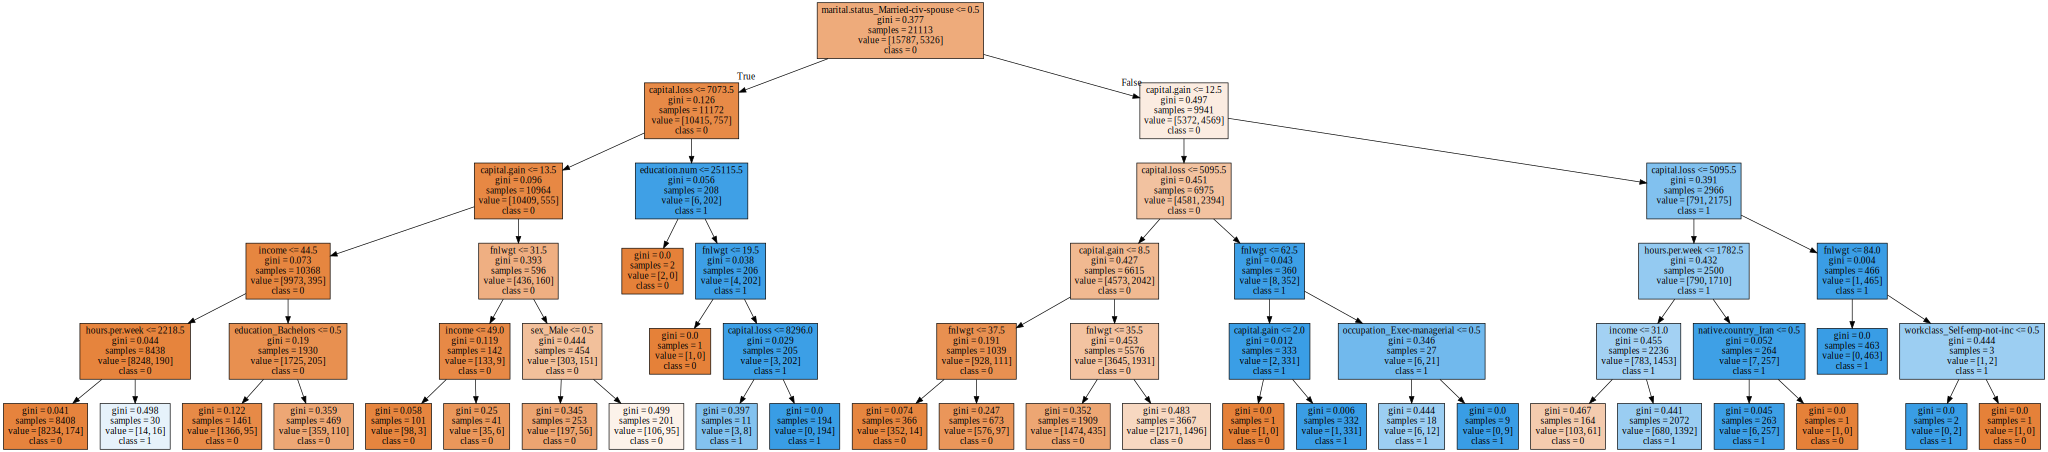

In [33]:
'''from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

import os
#os.environ["PATH"] += os.pathsep + 'c:/users/v-rakart/appdata/local/continuum/anaconda3/lib/site-packages/pydotplus'
os.environ["PATH"] += os.pathsep + 'C:/ProgramData/Anaconda3/Lib/site-packages/pydotplus'

graph = Source(tree.export_graphviz(dt_default, out_file=None, feature_names=features, class_names=['0', '1'], filled = True))
display(SVG(graph.pipe(format='svg')))'''

<hr>

### Hyperparameter Tuning

The default tree is quite complex, and we need to simplify it by tuning the hyperparameters. 

First, let's understand the parameters in a decision tree. You can read this in the documentation using ```help(DecisionTreeClassifier)```.


- **criterion** (Gini/IG or entropy): It defines the function to measure the quality of a split. Sklearn supports “gini” criteria for Gini Index & “entropy” for Information Gain. By default, it takes the value “gini”.
- **splitter**: It defines the strategy to choose the split at each node. Supports “best” value to choose the best split & “random” to choose the best random split. By default, it takes “best” value.
- **max_features**: It defines the no. of features to consider when looking for the best split. We can input integer, float, string & None value.
    - If an integer is inputted then it considers that value as max features at each split.
    - If float value is taken then it shows the percentage of features at each split.
    - If “auto” or “sqrt” is taken then max_features=sqrt(n_features).
    - If “log2” is taken then max_features= log2(n_features).
    - If None, then max_features=n_features. By default, it takes “None” value.
- **max_depth**: The max_depth parameter denotes maximum depth of the tree. It can take any integer value or None. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. By default, it takes “None” value.
- **min_samples_split**: This tells above the minimum no. of samples reqd. to split an internal node. If an integer value is taken then consider min_samples_split as the minimum no. If float, then it shows percentage. By default, it takes “2” value.
- **min_samples_leaf**: The minimum number of samples required to be at a leaf node. If an integer value is taken then consider - -min_samples_leaf as the minimum no. If float, then it shows percentage. By default, it takes “1” value.
- **max_leaf_nodes**: It defines the maximum number of possible leaf nodes. If None then it takes an unlimited number of leaf nodes. By default, it takes “None” value.
- **min_impurity_split**: It defines the threshold for early stopping tree growth. A node will split if its impurity is above the threshold otherwise it is a leaf.<br>



<hr>

### Tuning max_depth

Let's first try to find the optimum values for max_depth and understand how the value of max_depth affects the decision tree.

Here, we are creating a dataframe with max_depth in range 1 to 80 and checking the accuracy score corresponding to each max_depth. 

To reiterate, a grid search scheme consists of:

    - an estimator (classifier such as SVC() or decision tree)
    - a parameter space
    - a method for searching or sampling candidates (optional) 
    - a cross-validation scheme, and
    - a score function (accuracy, roc_auc etc.)

In [34]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 40)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [35]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.063154,0.005738,0.012335,0.002112,1,{'max_depth': 1},0.747633,0.747810,0.747750,0.747750,...,0.747738,0.000058,39,0.747765,0.747721,0.747735,0.747735,0.747735,0.747738,0.000014
1,0.083877,0.004391,0.014638,0.003189,2,{'max_depth': 2},0.813920,0.822164,0.822596,0.828754,...,0.822432,0.004854,17,0.824738,0.822499,0.822568,0.821029,0.822035,0.822574,0.001214
2,0.101445,0.001846,0.012658,0.001626,3,{'max_depth': 3},0.831913,0.839687,0.838228,0.841781,...,0.838630,0.003601,11,0.840725,0.838425,0.839027,0.838139,0.838316,0.838926,0.000947
3,0.122900,0.006070,0.012803,0.001582,4,{'max_depth': 4},0.831913,0.839687,0.838702,0.841544,...,0.839057,0.003923,10,0.840725,0.838425,0.839323,0.838494,0.844592,0.840312,0.002295
4,0.129819,0.002264,0.014055,0.004206,5,{'max_depth': 5},0.832623,0.844423,0.845097,0.844623,...,0.842277,0.004833,7,0.843389,0.846892,0.847789,0.841217,0.848736,0.845605,0.002842


Now let's visualize how train and test score changes with max_depth.

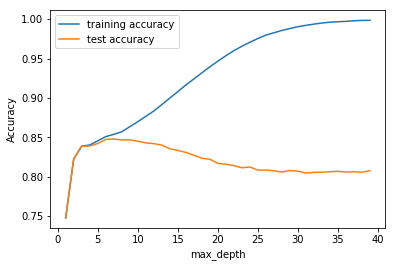

In [36]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

You can see that as we increase the value of max_depth, both training and test score increase till about max-depth = 10, after which the test score gradually reduces. Note that the scores are average accuracies across the 5-folds. 

Thus, it is clear that the model is overfitting the training data if the max_depth is too high. Next, let's see how the model behaves with other hyperparameters.

<hr>

### Tuning min_samples_leaf

The hyperparameter **min_samples_leaf** indicates the minimum number of samples required to be at a leaf.<br>

So if the values of min_samples_leaf is less, say 5, then the will be constructed even if a leaf has 5, 6 etc. observations (and is likely to overfit).<br>

Let's see what will be the optimum value for min_samples_leaf.

In [ ]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


You can see that at low values of min_samples_leaf, the tree gets a bit overfitted. At values > 100, however, the model becomes more stable and the training and test accuracy start to converge.

<hr>

### Tuning min_samples_split

The hyperparameter **min_samples_split** is the minimum no. of samples required to split an internal node. Its default value is 2, which means that even if a node is having 2 samples it can be furthur divided into leaf nodes.

In [ ]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


This shows that as you increase the min_samples_split, the tree overfits lesser since the model is less complex.

<hr>

## Grid Search to Find Optimal Hyperparameters

We can now use GridSearchCV to find multiple optimal hyperparameters together. Note that this time, we'll also specify the criterion (gini/entropy or IG).

In [ ]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)

In [ ]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

In [ ]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

<hr>

**Running the model with best parameters obtained from grid search.**

In [ ]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)
clf_gini.fit(X_train, y_train)

In [ ]:
# accuracy score
clf_gini.score(X_test,y_test)

In [ ]:
# plotting the tree
dot_data = StringIO()  
export_graphviz(clf_gini, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

You can see that this tree is too complex to understand. Let's try reducing the max_depth and see how the tree looks.

In [ ]:
# tree with max_depth = 3
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=3, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)
clf_gini.fit(X_train, y_train)

# score
print(clf_gini.score(X_test,y_test))

In [ ]:
# plotting tree with max_depth=3
dot_data = StringIO()  
export_graphviz(clf_gini, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
# classification metrics
from sklearn.metrics import classification_report,confusion_matrix
y_pred = clf_gini.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
# confusion matrix
print(confusion_matrix(y_test,y_pred))

<hr>